In [1]:
#Import Statements
import torch
from torch import nn, optim, utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#Download Pandas File
from google.colab import files
uploaded = files.upload()

Saving tank_test.csv to tank_test.csv
Saving tank_train.csv to tank_train.csv


In [18]:
#Input File
inp_folder = ""

#Read Pandas File
train_data = pd.read_csv(inp_folder+"tank_train.csv")
X_train = train_data.iloc[:, 1:].values
Y_train = train_data.iloc[:, 0].values

#Get Test Dataset
test_data = pd.read_csv(inp_folder+"tank_test.csv")
X_test = test_data.iloc[:, 1:].values
Y_test = test_data.iloc[:, 0].values

In [19]:
#Make a dataset file
class overwatchDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).float()

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        #Get Label
        retData = self.X[idx,:]
        retLab = self.Y[idx]
        #Return Answer
        return retData,retLab

In [27]:
#Get Both Dataloaders

#Train
train_data = overwatchDataset(X_train,Y_train)
trainLoader = utils.data.DataLoader(train_data, batch_size=64,
                                    shuffle=True,drop_last=True)

#Test
test_data = overwatchDataset(X_test,Y_test)
testLoader = utils.data.DataLoader(test_data, batch_size=64,
                                    shuffle=False,drop_last=True)

In [117]:
#Make the Network
dropout = 0.1
class overwatchModule(nn.Module):
  def __init__(self, input_size):
    super(overwatchModule,self).__init__()
    #Make Different layers
    self.overall = nn.Sequential(
        nn.Linear(input_size,256),
        nn.ReLU(),nn.BatchNorm1d(256),
        nn.Dropout(dropout),nn.Linear(256,512),
        nn.ReLU(),nn.BatchNorm1d(512),
        nn.Dropout(dropout),nn.Linear(512,1024),
        nn.ReLU(),nn.BatchNorm1d(1024),
        nn.Dropout(dropout),nn.Linear(1024,2000),
        nn.ReLU(),nn.BatchNorm1d(2000),
        nn.Dropout(dropout),nn.Linear(2000,4000),
        nn.ReLU(),nn.BatchNorm1d(4000),
        nn.Dropout(dropout),nn.Linear(4000,2000),
        nn.ReLU(),nn.BatchNorm1d(2000),
        nn.Dropout(dropout),nn.Linear(2000,1000),
        nn.ReLU(),nn.BatchNorm1d(1000),
        nn.Dropout(dropout),nn.Linear(1000,256),
        nn.ReLU(),nn.BatchNorm1d(256),
        nn.Dropout(dropout),nn.Linear(256,1))
  def forward(self,batchInput):
    #Go Through and Return Real Output
    overallOutput = self.overall(batchInput)
    return overallOutput

In [118]:
#Test Function
def test(model, test_load, device, criterion):
  #Set Model to Eval
  model.eval()
  test_loss = []
  n = 0

  #Go Through Loop
  for batch_idx, (inputs, targets) in enumerate(test_load):
     #Move it to device
     inputs = inputs.to(device)
     targets = torch.unsqueeze(targets,1)
     targets = targets.to(device)

     #Flatten Image
     inputs = inputs.view(inputs.shape[0],-1)

     #Train the Model for output
     outputs = model(inputs)
     loss = criterion(outputs, targets)

     #Get Loss
     test_loss.append(loss.item())

     #Empty Cache And Delete Variables
     del inputs
     del targets
     del outputs
     torch.cuda.empty_cache()

  #Get Standard Deviation
  n = len(test_loss)
  test_loss = np.array(test_loss)
  mean = test_loss.mean()
  sd = test_loss.std()
  low = mean-1.96*sd/np.sqrt(n)
  high = mean+1.96*sd/np.sqrt(n)
  #Calculate Lower, Upper, and Mean
  return mean, low, high

In [119]:
#Train Function
def train(model, optimizer, device, criterion, train_load, test_load,scheduler):
  #Move and Set Up Variables
  criterion = criterion.to(device)
  model = model.to(device)
  model.train()

  #Get Plot of Test_Acc, Test_Loss
  test_acc_list = []
  test_loss_list = []

  #Main Loop
  for epoch in range(epochs):
    avg_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_load):
      #Move it to device
      inputs = inputs.to(device)
      targets = torch.unsqueeze(targets,1)
      targets = targets.to(device)

      #Flatten Image
      inputs = inputs.view(inputs.shape[0],-1)

      #Train the Model for output
      outputs = model(inputs)
      outputs = outputs.reshape((outputs.shape[0],1))
      loss = criterion(outputs, targets)

      #Learn by Backpropagation
      loss.backward()

      #Optimize the Weights
      optimizer.step()

      #Print Epoch Info
      avg_loss += loss.item()
      if batch_idx % 100 == 0 and batch_idx != 0:
        print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_idx, avg_loss/150))
        avg_loss = 0
      
      #Empty Cache, Delete Variables, Reset Optimizer
      optimizer.zero_grad()
      del inputs
      del targets
      del outputs
      torch.cuda.empty_cache()

    #After Epoch Send it Through Test
    mean, low, high = test(model,test_load, device, criterion)
    test_loss_list.append(mean)
    print("Test Loss: {:.4f} | {:.4f} | {:.4f} ".format(low,mean,high))

    #Step Scheduler
    scheduler.step(mean)

    #Optional: Save Model
    #torch.save(model, './model_epoch_' + str(epoch)) 
  #Return Test Accuracy and Loss
  return test_loss_list

In [120]:
#Final Labels
learn_rate = 0.001
epochs = 50
model = overwatchModule(119)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learn_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.2,patience=4,verbose=True)

In [121]:
#Start learning
test_loss_list = train(model, optimizer, device, criterion, trainLoader, testLoader, scheduler)

Epoch: 1	Batch: 100	Avg-Loss: 0.1498
Epoch: 1	Batch: 200	Avg-Loss: 0.0319
Test Loss: 0.0209 | 0.0222 | 0.0234 
Epoch: 2	Batch: 100	Avg-Loss: 0.0104
Epoch: 2	Batch: 200	Avg-Loss: 0.0093
Test Loss: 0.0151 | 0.0159 | 0.0168 
Epoch: 3	Batch: 100	Avg-Loss: 0.0084
Epoch: 3	Batch: 200	Avg-Loss: 0.0080
Test Loss: 0.0136 | 0.0144 | 0.0151 
Epoch: 4	Batch: 100	Avg-Loss: 0.0080
Epoch: 4	Batch: 200	Avg-Loss: 0.0077
Test Loss: 0.0150 | 0.0157 | 0.0164 
Epoch: 5	Batch: 100	Avg-Loss: 0.0074
Epoch: 5	Batch: 200	Avg-Loss: 0.0075
Test Loss: 0.0135 | 0.0141 | 0.0148 
Epoch: 6	Batch: 100	Avg-Loss: 0.0071
Epoch: 6	Batch: 200	Avg-Loss: 0.0071
Test Loss: 0.0145 | 0.0152 | 0.0159 
Epoch: 7	Batch: 100	Avg-Loss: 0.0068
Epoch: 7	Batch: 200	Avg-Loss: 0.0069
Test Loss: 0.0142 | 0.0148 | 0.0155 
Epoch: 8	Batch: 100	Avg-Loss: 0.0067
Epoch: 8	Batch: 200	Avg-Loss: 0.0071
Test Loss: 0.0127 | 0.0133 | 0.0139 
Epoch: 9	Batch: 100	Avg-Loss: 0.0066
Epoch: 9	Batch: 200	Avg-Loss: 0.0069
Test Loss: 0.0123 | 0.0129 | 0.0135 
E

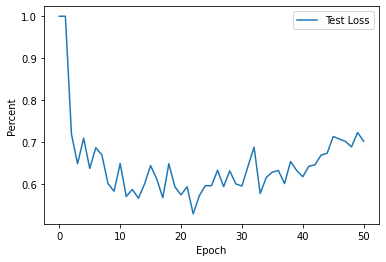

In [123]:
def display(test_loss):
  #Normalize Test Loss and Add 0 for Better Display
  test_loss = [i/max(test_loss) for i in test_loss]
  test_loss.insert(0,1.0)

  #Print The Results
  plt.plot(test_loss, label = "Test Loss")
  plt.ylabel('Percent')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()
#Display Result
display(test_loss_list)